# Анализ авиакатастроф за 1908 - 2009 гг

In [1]:
from calendar import month_abbr
from datetime import datetime
import random

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt, style
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS

random.seed(42)
style.use('seaborn')
weekday_abbr = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

## Импорт и первичный осмотр данных
Источник: https://opendata.socrata.com/Government/Airplane-Crashes-and-Fatalities-Since-1908/q2te-8cvq

In [2]:
df = pd.read_csv('dataset.zip', compression='zip', sep=',')

Рамерность данных:

In [3]:
df.shape

(5268, 13)

Описание датафрейма:

In [4]:
df.describe()

,Aboard,Fatalities,Ground
count,5246.000000,5256.000000,5246.000000
mean,27.554518,20.068303,1.608845
std,43.076711,33.199952,53.987827
min,0.000000,0.000000,0.000000
25%,5.000000,3.000000,0.000000
50%,13.000000,9.000000,0.000000
75%,30.000000,23.000000,0.000000
max,644.000000,583.000000,2750.000000


Первые записи:

In [5]:
df.head()

,Date,Time,Location,Operator,Flight #,Route,Type,Registration,cn/In,Aboard,Fatalities,Ground,Summary
0,09/17/1908,17:18,"Fort Myer, Virginia",Military - U.S. Army,NaN,Demonstration,Wright Flyer III,NaN,1,2.0,1.0,0.0,"During a demonstration flight, a U.S. Army fly..."
1,07/12/1912,06:30,"AtlantiCity, New Jersey",Military - U.S. Navy,NaN,Test flight,Dirigible,NaN,NaN,5.0,5.0,0.0,First U.S. dirigible Akron exploded just offsh...
2,08/06/1913,NaN,"Victoria, British Columbia, Canada",Private,-,NaN,Curtiss seaplane,NaN,NaN,1.0,1.0,0.0,The first fatal airplane accident in Canada oc...
3,09/09/1913,18:30,Over the North Sea,Military - German Navy,NaN,NaN,Zeppelin L-1 (airship),NaN,NaN,20.0,14.0,0.0,The airship flew into a thunderstorm and encou...
4,10/17/1913,10:30,"Near Johannisthal, Germany",Military - German Navy,NaN,NaN,Zeppelin L-2 (airship),NaN,NaN,30.0,30.0,0.0,Hydrogen gas which was being vented was sucked...


Последние записи:

In [6]:
df.tail()

,Date,Time,Location,Operator,Flight #,Route,Type,Registration,cn/In,Aboard,Fatalities,Ground,Summary
5263,05/20/2009,06:30,"Near Madiun, Indonesia",Military - Indonesian Air Force,NaN,Jakarta - Maduin,Lockheed C-130 Hercules,A-1325,1982,112.0,98.0,2.0,"While on approach, the military transport cras..."
5264,05/26/2009,NaN,"Near Isiro, DemocratiRepubliCongo",Service Air,NaN,Goma - Isiro,Antonov An-26,9Q-CSA,5005,4.0,4.0,NaN,The cargo plane crashed while on approach to I...
5265,06/01/2009,00:15,"AtlantiOcean, 570 miles northeast of Natal, Br...",Air France,447,Rio de Janeiro - Paris,Airbus A330-203,F-GZCP,660,228.0,228.0,0.0,The Airbus went missing over the AtlantiOcean ...
5266,06/07/2009,08:30,"Near Port Hope Simpson, Newfoundland, Canada",Strait Air,NaN,Lourdes de BlanSablon - Port Hope Simpson,Britten-Norman BN-2A-27 Islander,C-FJJR,424,1.0,1.0,0.0,The air ambulance crashed into hills while att...
5267,06/08/2009,NaN,"State of Arunachal Pradesh, India",Military - Indian Air Force,NaN,Mechuka for Jorhat,Antonov An-32,NaN,NaN,13.0,13.0,0.0,The military transport went missing while en r...


Проверим на наличие пустых значений:

In [7]:
df.isnull().sum()

Date               0
Time            2219
Location          20
Operator          18
Flight #        4199
Route           1706
Type              27
Registration     335
cn/In           1228
Aboard            22
Fatalities        12
Ground            22
Summary          390
dtype: int64

## Предварительная обработка данных

Чистим столбец со временем:

In [8]:
df['Time'] = df['Time'] \
    .replace(np.nan, '00:00') \
    .str.strip('c: ') \
    .str.replace('.', ':') \
    .str.replace('\'', ':') \
    .str.replace('114:20', '14:20') \
    .str.replace('0943', '09:43')

# Объединяем дату и время
df['Date'] += ' ' + df['Time']

# Приводим дату к типу "datetime"
df['Date'] = df['Date'] \
    .apply(lambda x: datetime.strptime(x, '%m/%d/%Y %H:%M'))

Приводим название опреатора к единому регистру:

In [9]:
df['Operator'] = df['Operator'] \
    .str.upper() \
    .str.replace('A B AEROTRANSPORT', 'AB AEROTRANSPORT')

Разделяем поле `Location` на 2 - `City` и `Country`:

In [10]:
df[['City', 'Country']] = df['Location'].str.rsplit(',', 1, expand=True)

Заменяем `NaN` на пустые строки в столбце `Summmary`:

In [11]:
df['Summary'] = df['Summary'].fillna(value='')

## Анализ

### Сколько произошло катастроф по годам, месяцам, дням недели, часам

Катастрофы по годам:

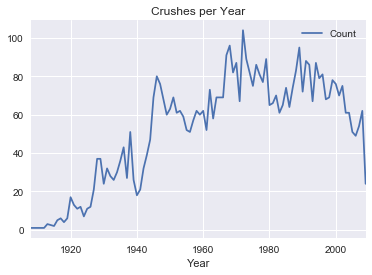

In [12]:
df \
    .groupby(df['Date'].dt.year.rename('Year')) \
    .count() \
    .rename({'Date': 'Count'}, axis='columns') \
    .plot(y='Count', title='Crushes per Year');

Катастрофы по месяцам:

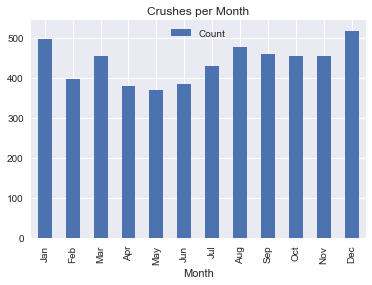

In [13]:
df \
    .groupby(df['Date'].dt.month.rename('Month')) \
    .count() \
    .rename({'Date': 'Count'}, axis='columns') \
    .rename(lambda x: month_abbr[x], axis='index') \
    .plot(y='Count', title='Crushes per Month', kind='bar');

Катастрофы по дням недели:

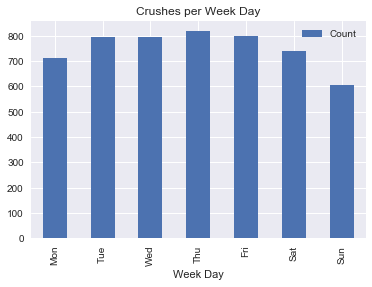

In [14]:
df \
    .groupby(df['Date'].dt.weekday.rename('Week Day')) \
    .count() \
    .rename({'Date': 'Count'}, axis='columns') \
    .rename(lambda x: weekday_abbr[x], axis='index') \
    .plot(y='Count', title='Crushes per Week Day', kind='bar');

Катастрофы по часам:

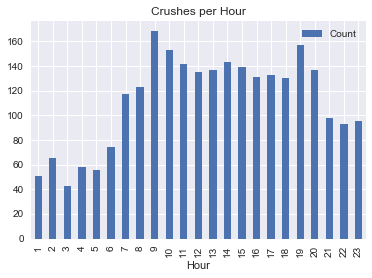

In [15]:
df[(df['Date'].dt.hour != 0) & (df['Date'].dt.minute != 0)] \
    .groupby(df['Date'].dt.hour.rename('Hour')) \
    .count() \
    .rename({'Date': 'Count'}, axis='columns') \
    .plot(y='Count', title='Crushes per Hour', kind='bar');

Больше всего катастроф происходило:
- По годам: в промежутке 1965-1980 гг
- По месяцам: в декабре и январе
- По дням недели: в четверг
- По часам - в 9 часов утра

### Сколько человек было на борту, сколько выжило

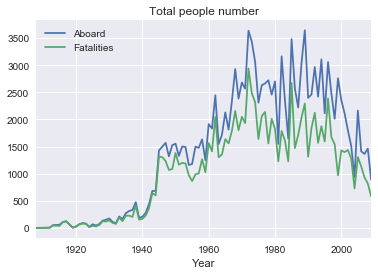

In [16]:
df \
    .groupby(df['Date'].dt.year.rename('Year')) \
    .sum() \
    .plot(y=['Aboard', 'Fatalities'], title='Total people number');

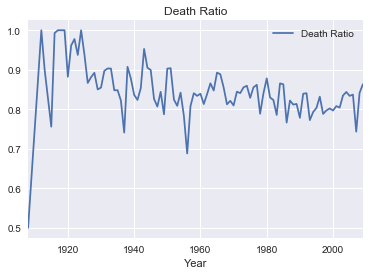

In [17]:
df['Death Ratio'] = df['Fatalities'] / df['Aboard']
df \
    .groupby(df['Date'].dt.year.rename('Year')) \
    .mean() \
    .plot(y='Death Ratio', title='Death Ratio');

### Какие операторы и типы самолетов самые опасные

Топ 10 опасных операторов:

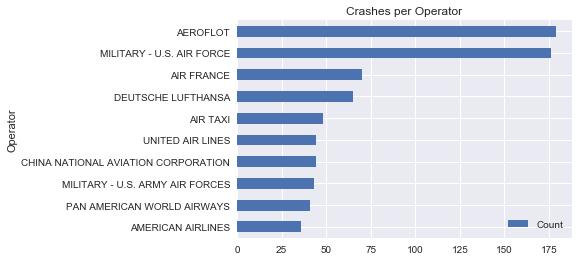

In [18]:
df \
    .groupby('Operator')[['Operator']] \
    .count() \
    .rename({'Operator': 'Count'}, axis='columns') \
    .sort_values(by='Count', ascending=True) \
    .tail(10) \
    .plot(title='Crashes per Operator', kind='barh');

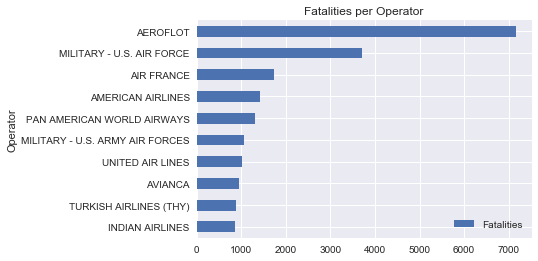

In [19]:
df \
    .groupby('Operator')[['Fatalities']] \
    .sum() \
    .sort_values(by='Fatalities', ascending=True) \
    .tail(10) \
    .plot(title='Fatalities per Operator', kind='barh');

Топ 10 опасных типов самолетов:

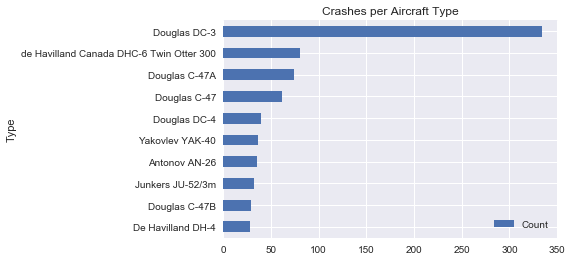

In [20]:
df \
    .groupby('Type')[['Type']] \
    .count() \
    .rename({'Type': 'Count'}, axis='columns') \
    .sort_values(by='Count', ascending=True) \
    .tail(10) \
    .plot(title='Crashes per Aircraft Type', kind='barh');

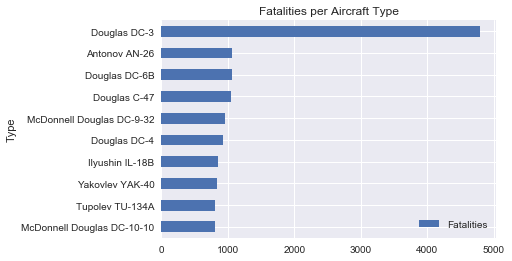

In [21]:
df \
    .groupby('Type')[['Fatalities']] \
    .sum() \
    .sort_values(by='Fatalities', ascending=True) \
    .tail(10) \
    .plot(title='Fatalities per Aircraft Type', kind='barh');

### В каких странах чаще всего случались катастрофы

Катастрофы по странам:

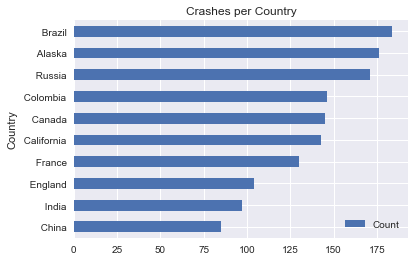

In [22]:
df \
    .groupby('Country')[['Country']] \
    .count() \
    .rename({'Country': 'Count'}, axis='columns') \
    .sort_values(by='Count', ascending=True) \
    .tail(10) \
    .plot(title='Crashes per Country', kind='barh');

Жертвы по странам:

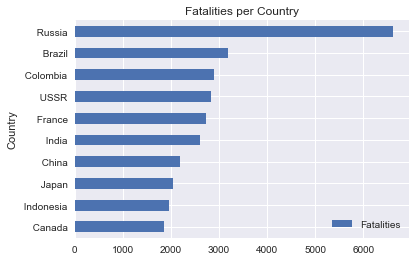

In [23]:
df \
    .groupby('Country')[['Fatalities']] \
    .sum() \
    .sort_values(by='Fatalities', ascending=True) \
    .tail(10) \
    .plot(title='Fatalities per Country', kind='barh');

### Самые используемые слова для описания причины крушения

In [24]:
text = str(df['Summary'].tolist())
stopwords = set(STOPWORDS)
stopwords.add('aircraft')
stopwords.add('plane')

wc = WordCloud(background_color='white', max_words=100,
               stopwords=stopwords)

Самые часто используемые слова:

In [25]:
words = wc.process_text(text)
sorted(words.items(), key=lambda kv: kv[1], reverse=True)[:10]

[('crashed', 747),
 ('pilot', 693),
 ('flight', 505),
 ('crew', 477),
 ('approach', 468),
 ('airport', 427),
 ('en route', 398),
 ('landing', 302),
 ('weather condition', 279),
 ('attempting land', 269)]

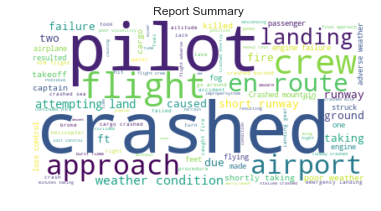

In [26]:
wc.generate_from_frequencies(words)
plt.figure()
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Report Summary')
plt.show()

### Кластерный анализ причин крушения

In [27]:
vectorizer = TfidfVectorizer(stop_words='english')
vectorizer = vectorizer.fit(df['Summary'])
summary = vectorizer.fit_transform(df['Summary'])

In [28]:
km = KMeans(n_clusters=6, max_iter=100, n_init=1, random_state=42)
km.fit(summary)
df['Cluster'] = km.labels_ + 1  # Labels are zero-based

Самые используемые слова в каждом кластере:

In [29]:
centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i, cluster in enumerate(centroids, 1):
    print('Cluster {}:'.format(i), [terms[idx] for idx in cluster[:10]])

Cluster 1: ['engine', 'takeoff', 'failure', 'crashed', 'aircraft', 'plane', 'shortly', 'failed', 'emergency', 'right']
Cluster 2: ['cargo', 'plane', 'crashed', 'attempting', 'runway', 'struck', 'land', 'mountain', 'approach', 'engine']
Cluster 3: ['en', 'route', 'crashed', 'disappeared', 'mountain', 'plane', 'cargo', 'mountains', 'aircraft', 'mountainous']
Cluster 4: ['approach', 'crashed', 'runway', 'landing', 'attempting', 'land', 'mountain', 'short', 'fog', 'aircraft']
Cluster 5: ['crashed', 'aircraft', 'plane', 'taking', 'pilot', 'flight', 'shortly', 'control', 'shot', 'crew']
Cluster 6: ['weather', 'conditions', 'poor', 'vfr', 'adverse', 'flight', 'mountain', 'continued', 'crashed', 'pilot']


- Кластер 1: Отказ двигателя при экстренной посадке
- Кластер 2: Столкновение грузового самолета с землей
- Кластер 3: Крушени в пути, обломки в недоступной местности
- Кластер 4: Крушение при заходе на посадку на разрушенную полосу в горах
- Кластер 5: Недостаточно информации
- Кластер 6: Крушение из-за плохих погодных условий (низкая вдимость)

Катастрофы по кластерам:

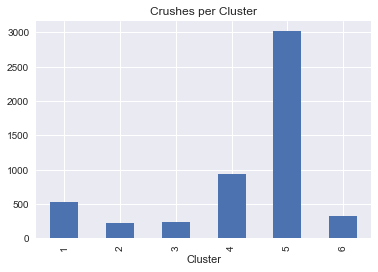

In [30]:
df \
    .groupby('Cluster')['Cluster'] \
    .count() \
    .plot(title='Crushes per Cluster', kind='bar');

Жертвы по кластерам:

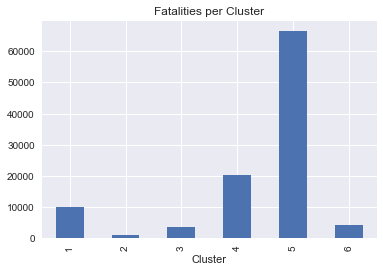

In [31]:
df \
    .groupby('Cluster')['Fatalities'] \
    .sum() \
    .plot(title='Fatalities per Cluster', kind='bar');